## Reading Data

In [54]:
import pandas as pd
import numpy as np
# Reading Data
df = pd.read_csv("cardio_train.csv",sep=';')
df.drop("id",axis=1,inplace=True)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## Data PreProcessing

In [55]:
continuous_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
for col in continuous_cols:
    mean_val = df[col].mean()
    df.loc[df[col]<mean_val, col] = 0
    df.loc[df[col]>=mean_val, col] = 1

df['weight'] = df['weight'].astype(int)
df

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,2,1,0,0,0,1,1,0,0,1,0
1,1,1,0,1,1,0,3,1,0,0,1,1
2,0,1,1,0,1,0,3,1,0,0,0,1
3,0,2,1,1,1,1,1,1,0,0,1,1
4,0,1,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0,2,1,1,0,0,1,1,1,0,1,0
69996,1,1,0,1,1,0,2,2,0,0,1,1
69997,0,2,1,1,1,0,3,1,0,1,0,1
69998,1,1,0,0,1,0,1,2,0,0,0,1


## Data spliting

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', axis=1), df['cardio'], test_size=0.2, random_state=42)
y = df['cardio']

## Implementation of the Decision Tree ID3 Algorithm

In [57]:
class DecisionTreeManually:
    def __init__(self, max_depth):
        self.max_depth = max_depth
        self.tree = {}

    def _calculate_entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probs = counts / np.sum(counts)
        entropy = -np.sum(probs * np.log2(probs))

        return entropy

    def _calculate_information_gain(self, X, y, feature_idx, thresholds):
        n_samples = len(y)
        parent_entropy = self._calculate_entropy(y)

        child_entropy = 0
        for threshold in thresholds:
            idx = X[:, feature_idx] == threshold
            child_entropy += np.sum(idx) / n_samples * self._calculate_entropy(y[idx])

        gain = parent_entropy - child_entropy

        return gain

    def _get_best_feature(self, X, y):
        n_samples, n_features = X.shape
        best_feature_idx = None
        best_thresholds = None
        max_info_gain = -1

        for feature_idx in range(n_features):
            feature_values = X[:, feature_idx]
            thresholds = np.unique(feature_values)

            info_gain = self._calculate_information_gain(X, y, feature_idx, thresholds)

            if info_gain > max_info_gain:
                max_info_gain = info_gain
                best_feature_idx = feature_idx
                best_thresholds = thresholds

        return best_feature_idx, best_thresholds

    def _get_most_common_label(self, y):
        unique, counts = np.unique(y, return_counts=True)
        index = np.argmax(counts)
        label = unique[index]
        return label

    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))

        # Stopping criteria
        if depth >= self.max_depth or n_classes == 1:
            return self._get_most_common_label(y)

        # Split the data based on the best feature
        best_feature_idx, thresholds = self._get_best_feature(X, y)

        sub_trees = {}
        for threshold in thresholds:
            idx = X[:, best_feature_idx] == threshold
            sub_tree = self._build_tree(X[idx], y[idx], depth+1)
            sub_trees[threshold] = sub_tree

        # Node
        node = {'feature_idx': best_feature_idx,
                'thresholds': thresholds,
                'sub_trees': sub_trees}

        return node

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _traverse_tree(self, x, node):
        if isinstance(node, np.int64):
            return node

        feature_idx = node['feature_idx']
        thresholds = node['thresholds']
        sub_trees = node['sub_trees']

        for threshold in thresholds:
            if x[feature_idx] == threshold:
                return self._traverse_tree(x, sub_trees[threshold])
            
        return self._get_most_common_label(y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.tree) for x in X])

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y == y_pred)


## Comparing Manual vs Sklearn Tree

In [58]:
manulModel = DecisionTreeManually(5)
manulModel.fit(np.array(X_train), np.array(y_train))
yPredManual = manulModel.predict(X_test.values)
accuracyManual = manulModel.score(np.array(X_test), np.array(y_test))

print("Accuracy:", accuracyManual)

Accuracy: 0.7312142857142857


In [59]:
from sklearn.metrics import accuracy_score, classification_report , confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

ImplementedModel = DecisionTreeClassifier( max_depth= 5)
ImplementedModel.fit(X_train,y_train)
y_pred1 = ImplementedModel.predict(X_test)

print('Accuracy Score', ImplementedModel.score(np.array(X_test), np.array(y_test)))

Accuracy Score 0.7312142857142857


c:\Users\ahmad\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


## Given Data set

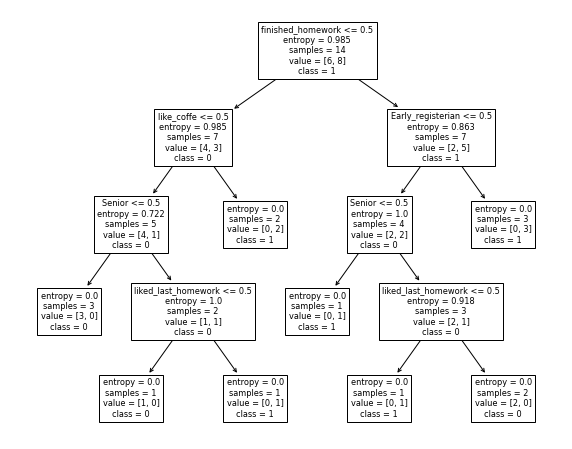

In [72]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the data frame
data = {'Early_registerian': [1,1,0,0,0,0,1,0,0,1,1,0,0,1],
        'finished_homework': [1,1,0,1,1,0,0,1,0,0,1,1,0,0],
        'Senior': [0,1,1,1,1,1,0,0,1,0,1,1,0,0],
        'like_coffe': [0,0,0,0,0,1,0,1,0,0,0,1,0,1],
        'liked_last_homework': [1,1,0,1,0,1,1,1,1,0,0,1,1,0],
        'A': [1,1,0,0,1,1,0,1,1,0,1,0,0,1]}
df = pd.DataFrame(data)

# Create a decision tree classifier
clf = DecisionTreeClassifier(criterion='entropy',random_state=42)

# Train the classifier on the full data
clf.fit(df.drop('A', axis=1), df['A'])

# Plot the decision tree
plt.figure(figsize=(10, 8))
plot_tree(clf, feature_names=df.columns[:-1], class_names=['0', '1'])
plt.show()